In [1]:
# import necessary packages

import os
import torch
import pickle
import tables
import numpy as np
import torch.nn as nn
from torch import cat
from torch.fft import *
from scipy.io import savemat
from einops import rearrange
from scipy.io import loadmat
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter

In [2]:
# define utility functions

def ifft2c(k):
    return ifftshift(ifft2(fftshift(k)))
    
def fft2c(x):
    return fftshift(fft2(ifftshift(x)))

def add_rician(img, std=5e-3):
    std = img.max() * std

    rdm1 = torch.randn(img.shape)
    rdm2 = torch.randn(img.shape)

    x = std * rdm1 + img
    y = std * rdm2

    module = torch.sqrt(torch.pow(x,2) + torch.pow(y,2))
    return module

In [4]:
# define dataset

class dataset(Dataset):
    def __init__(self, datapath, nch, crng, noi_level) -> None:
        super().__init__()
        names = os.listdir(datapath)

        self.datalist = []
        for name in names:
            mats = os.listdir(os.path.join(datapath,name))
            for mat in mats:
                data = loadmat(os.path.join(datapath,name,mat))
                imgs, offs = data['imgs'], data['offs'][0]
                imgs = imgs.transpose(2,0,1)
                imgs = torch.from_numpy(imgs)
                for i in range(len(offs)-nch+1):
                    self.datalist.append(imgs[i:i+nch])
        self.crng = crng
        self.noi_level = noi_level
    
    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, index):
        img = self.datalist[index]
        src = add_rician(img,self.noi_level).float()
        tgt = add_rician(img,self.noi_level).float()
        kf = fft2c(src)
        kc = torch.zeros_like(kf)
        kc[:,self.crng,:] = kf[:,self.crng,:]
        return src, tgt, kc

In [5]:
# define transformer

class Attention(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8):
        super().__init__()
        self.num_heads = heads
        self.dim_head = dim_head
        self.to_q = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_k = nn.Linear(dim, dim_head * heads, bias=False)
        self.to_v = nn.Linear(dim, dim_head * heads, bias=False)
        self.rescale = nn.Parameter(torch.ones(heads, 1, 1))
        self.proj = nn.Linear(dim_head * heads, dim, bias=True)
        self.pos_emb = nn.Conv2d(dim, dim, 3, 1, 1, bias=False, groups=dim)
        self.dim = dim
    def forward(self, x_in):
        b, c, h, w = x_in.shape
        x = x_in.permute(0, 2, 3, 1).reshape(b,h*w,c)
        # b, hw, hd
        q_inp = self.to_q(x)
        k_inp = self.to_k(x)
        v_inp = self.to_v(x)
        # b, h, hw, d
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), (q_inp, k_inp, v_inp))
        # b, h, d, hw
        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)
        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)
        # attn: b, h, d, d
        attn = (k @ q.transpose(-2, -1))
        attn = attn * self.rescale
        attn = attn.softmax(dim=-1)
        # x: b, h, d, hw
        x = attn @ v
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(b, h * w, self.num_heads * self.dim_head)
        # out: b, c, h, w
        out_c = self.proj(x).view(b, h, w, c).permute(0, 3, 1, 2)
        out_p = self.pos_emb(x_in)
        out = out_c + out_p
        return out

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim, dim * mult, 1, 1, bias=False),
            nn.GELU(),
            nn.Conv2d(dim * mult, dim * mult, 3, 1, 1, bias=False, groups=dim * mult),
            nn.GELU(),
            nn.Conv2d(dim * mult, dim, 1, 1, bias=False),
        )
    def forward(self, x):
        return self.net(x)

class Transformer(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, num_blocks=2):
        super().__init__()
        self.blocks = nn.ModuleList([])
        for _ in range(num_blocks):
            self.blocks.append(
                nn.ModuleList([
                    Attention(dim=dim, dim_head=dim_head, heads=heads),
                    FeedForward(dim=dim)
                ])
            )
    def forward(self, x):
        for (attn, ff) in self.blocks:
            x = attn(x) + x
            x = ff(x) + x
        return x

class TFNet(nn.Module):
    def __init__(self, nch, dim=16, stages=3, num_blocks=[2,2,2]):
        super().__init__()
        dim_stage, dim_in = dim, nch
        self.stages = nn.ModuleList()
        # embedding - transformer - mapping
        for i in range(stages):
            self.stages.append(
                nn.Sequential(OrderedDict([
                    ('embedding', nn.Sequential(nn.Conv2d(dim_in, dim_stage, 3, 1, 1, bias=False), nn.GELU())),
                    ('transformer', Transformer(dim_stage, dim, dim_stage//dim, num_blocks[i])),
                    ('mapping', nn.Sequential(nn.Conv2d(dim_stage, dim_stage*2, 3, 1, 1, bias=False), nn.GELU()))
                ]))
            )
            dim_stage *= 2
            dim_in = dim_stage
        # output
        self.convout = nn.Conv2d(dim_stage, nch, 1)
    def forward(self, x, kc):
        for layer in self.stages:
            x = layer(x)
        out = self.convout(x)
        out = fft2c(out) * (kc == 0) + kc
        out = abs(ifft2c(out))
        return out

In [6]:
# define learning rate scheduler

class PolyScheduler(LambdaLR):
    def __init__(self, optimizer, t_total, exponent=0.9, last_epoch=-1):
        self.t_total = t_total
        self.exponent = exponent
        super(PolyScheduler, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        return (1 - step / self.t_total)**self.exponent

torch.Size([9, 48, 48]) torch.Size([9, 48, 48]) torch.Size([9, 48, 48])


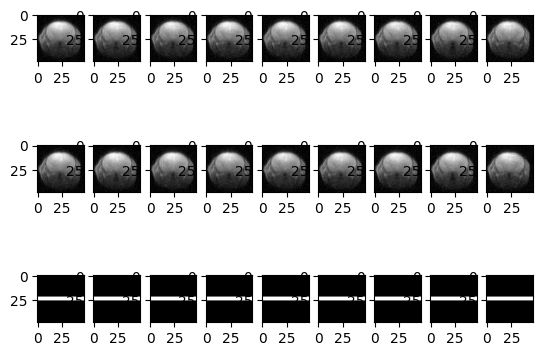

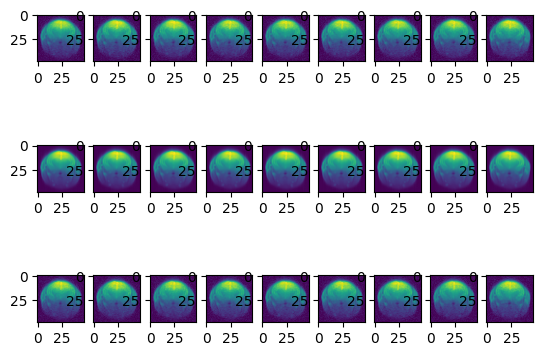

In [7]:
# run training

nch = 9
crng = slice(22,26)     # index range of center k-space
noi_level = 2e-2

trainset = dataset('data/processed', nch, crng, noi_level)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, drop_last=True)

# take a snapshot
src, tgt, kc = trainset.__getitem__(0)
print(src.shape, tgt.shape, kc.shape)
for i in range(nch):
    plt.subplot(3, nch, i+1)
    plt.imshow(src[i].cpu().numpy(), cmap='gray')
    plt.subplot(3, nch, nch+i+1)
    plt.imshow(tgt[i].cpu().numpy(), cmap='gray')
    plt.subplot(3, nch, 2*nch+i+1)
    plt.imshow(abs(kc)[i].cpu().numpy()>0, cmap='gray')
plt.show()

# hyper-parameters
lr, weight_decay, momentum, epochs = 1e-2, 1e-4, 0.9, 200

net = TFNet(nch).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=weight_decay)
scheduler = PolyScheduler(optimizer, t_total=epochs)
criterion = nn.L1Loss()

iter = 0
writer = SummaryWriter()
for epoch in range(epochs):
    for src, tgt, kc in trainloader:
        src, tgt, kc = src.cuda(), tgt.cuda(), kc.cuda()
        rec = net(src,kc)
        loss = criterion(rec, tgt)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        writer.add_scalar('Loss/train', loss.item(), iter)
        iter = iter + 1
    scheduler.step()
torch.save(net.state_dict(), 'variables/n2ncest.pth')

# take a snapshot of xr and xf
for i in range(nch):
    plt.subplot(3, nch, i+1)
    plt.imshow(abs(src)[0][i].detach().cpu().numpy())
    plt.subplot(3, nch, nch+i+1)
    plt.imshow(abs(rec)[0][i].detach().cpu().numpy())
    plt.subplot(3, nch, 2*nch+i+1)
    plt.imshow(abs(tgt)[0][i].detach().cpu().numpy())
plt.show()

In [ ]:
# run validation on noised images

nch = 9
crng = slice(22,26)
net = TFNet(nch).cuda()
net.load_state_dict(torch.load('variables/n2ncest.pth'))

net.requires_grad_(False)
net.eval()

datapath = ''
name = ''
noi_level = 4e-3

data = loadmat(os.path.join(datapath,name))
imgs, offs = data['imgs'], data['offs'][0]
imgs = imgs.transpose(2,0,1)
imgs = torch.from_numpy(imgs)
nois = add_rician(imgs, std=noi_level)

den = torch.zeros_like(imgs)
cnt = torch.zeros_like(imgs)
for i in range(len(offs)-nch+1):
    src = nois[i:i+nch][None].float().cuda()
    kf = fft2c(src[i:i+nch][None].float().cuda())
    kc = torch.zeros_like(kf)
    kc[:,:,crng,:] = kf[:,:,crng,:]
    rec = net(src,kc).cpu().numpy()
    den[i:i+nch] += rec
    cnt[i:i+nch] += 1

den = den / cnt

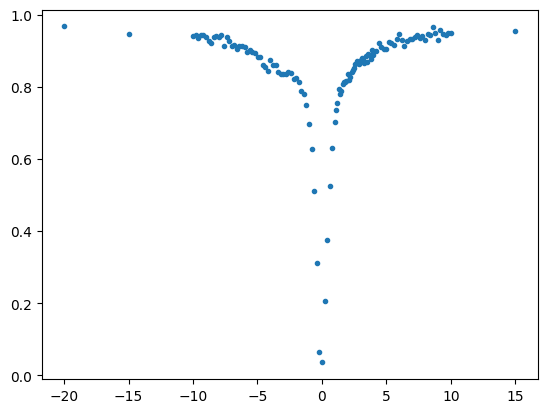

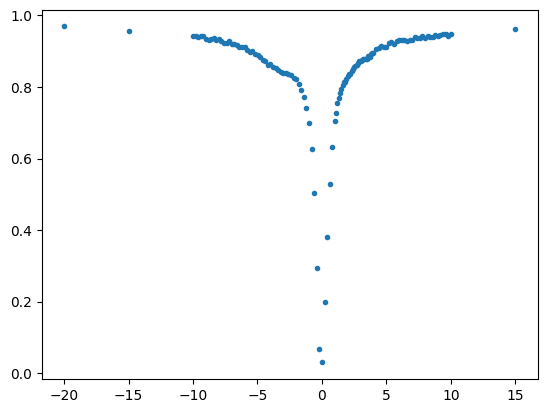

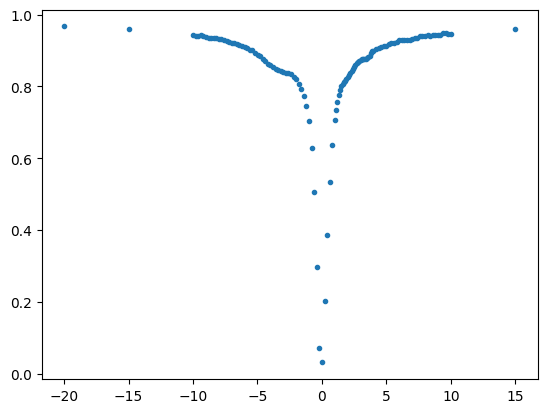

In [11]:
# plot z-spectrum

x, y = 17, 15
nM0 = 2     # the number of M0 images for normalization

plt.plot(offs[nM0:], nois[nM0:,x,y]/torch.mean(nois[:nM0,x,y],0,keepdims=True),'.')
plt.show()
plt.plot(offs[nM0:], imgs[nM0:,x,y]/torch.mean(imgs[:nM0,x,y],0,keepdims=True),'.')
plt.show()
plt.plot(offs[nM0:], den[nM0:,x,y]/torch.mean(den[:nM0,x,y],0,keepdims=True),'.')
plt.show()